In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import cv2
import tensorflow as tf
import os
%matplotlib inline

### Loading and preprocessing the training data

In [3]:
# Define img_height, img_width
img_height=164
img_width=164

#Loading the train.csv file and created and empty dataframe
data = pd.read_csv("E:/Data Science/Damaged Vehicle Classification/train/train.csv")
df = pd.DataFrame(columns=['image_id','filename','label','image'])

#Sorting the images
file_path = "E:/Data Science/Damaged Vehicle Classification/train/images"
sorted_image_list = list(os.listdir(file_path))
sorted_image_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#Reading the pasting the images into the created dataframe
for i, j in zip(sorted_image_list,range(len(os.listdir(file_path)))):
    img = cv2.imread(os.path.join(file_path,i))
    img = cv2.resize(img, (img_height, img_width))
    df = df._append({'image_id':data['image_id'][j],'filename':data['filename'][j],'label':data['label'][j],'image':img},ignore_index=True)
df.head()

,image_id,filename,label,image
0,1,1.jpg,2,"[[[234, 232, 232], [237, 237, 236], [245, 245,..."
1,2,2.jpg,4,"[[[5, 10, 155], [3, 8, 153], [11, 9, 162], [13..."
2,3,3.jpg,2,"[[[238, 238, 238], [209, 209, 209], [129, 131,..."
3,4,4.jpg,3,"[[[47, 21, 25], [49, 14, 19], [60, 30, 35], [5..."
4,5,5.jpg,5,"[[[193, 223, 238], [187, 207, 224], [205, 227,..."


### Loading and preprocessing the test data

In [3]:
# Define img_height, img_width
img_height=164
img_width=164

#Loading the train.csv file and created and empty dataframe
data_test = pd.read_csv("E:/Data Science/Damaged Vehicle Classification/test/test.csv")
df_test = pd.DataFrame(columns=['image_id','filename','image'])

#Sorting the images
file_path_test = "E:/Data Science/Damaged Vehicle Classification/test/images"
sorted_image_test_list = list(os.listdir(file_path_test))
sorted_image_test_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#Reading the pasting the images into the created dataframe
for i, j in zip(sorted_image_test_list,range(len(os.listdir(file_path_test)))):
    img = cv2.imread(os.path.join(file_path_test,i))
    img = cv2.resize(img, (img_height, img_width))
    df_test = df_test.append({'image_id':data_test['image_id'][j],'filename':data_test['filename'][j],'image':img},ignore_index=True)
df_test.head()

,image_id,filename,image
0,7201,7201.jpg,"[[[143, 147, 158], [137, 140, 152], [137, 141,..."
1,7202,7202.jpg,"[[[161, 149, 143], [153, 141, 135], [160, 148,..."
2,7203,7203.jpg,"[[[95, 107, 117], [102, 116, 126], [82, 98, 10..."
3,7204,7204.jpg,"[[[5, 3, 2], [10, 8, 7], [9, 7, 7], [10, 8, 8]..."
4,7205,7205.jpg,"[[[25, 41, 48], [26, 42, 49], [33, 49, 56], [1..."


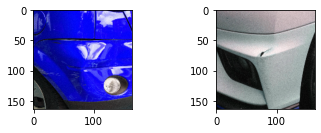

In [4]:
#Visualizing some of the images
plt.subplot(2,2,1)
plt.imshow(df['image'][1])
plt.subplot(2,2,2)
plt.imshow(df['image'][7199])

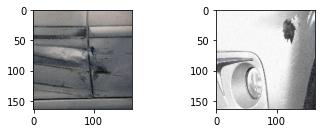

In [5]:
plt.subplot(2,2,1)
plt.imshow(df['image'][78])
plt.subplot(2,2,2)
plt.imshow(df['image'][935])

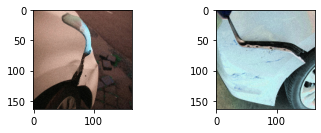

In [6]:
plt.subplot(2,2,1)
plt.imshow(df['image'][2000])
plt.subplot(2,2,2)
plt.imshow(df['image'][4590])

2    2349
4    2079
5    1185
6     882
3     534
1     171
Name: label, dtype: int64


<AxesSubplot:ylabel='label'>

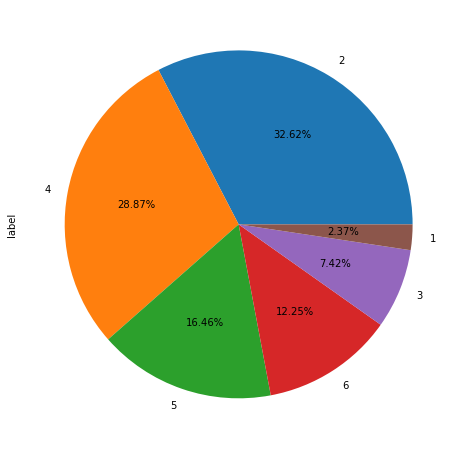

In [7]:
#Checking the distribution of target variable
print(df['label'].value_counts())
plt.figure(figsize=(20,8))
df['label'].value_counts().plot(kind='pie',autopct='%.2f%%')

The dataset is unbalanced as only 2.37% and 7.42% of the images are of class 1 and 3.

In [4]:
# Creating X_train and y_train

x = df['image']

print(x.shape)

(7200,)


In [5]:
# Reshaping x suitable for the model

x_train = []

for i, j in enumerate(x):
    x_train.append(j)

x_train= np.array(x_train, np.float32) / 255. # Converting the train data to an array and then normalizing it
x_train.shape

(7200, 164, 164, 3)

In [6]:
# Converting encoded 'breed' feature to categorical columns

y = df['label']

#y_train = tf.keras.utils.to_categorical(y, num_classes=None, dtype='int')
y_train = np.array(pd.get_dummies(y))
y_train.shape

(7200, 6)

In [11]:
# Reshaping x_test suitable for the model

x_test_data = df_test['image']
x_test = []

for i, j in enumerate(x_test_data):
    x_test.append(j)

x_test= np.array(x_test, np.float32) / 255. # Converting the train data to an array and then normalizing it
x_test.shape

(4800, 164, 164, 3)

### Model Building and Training

### Model1

In [7]:
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(47)
import random
random.seed(47)
tf.random.set_seed(47)

In [9]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

base_model = MobileNet(input_shape=x_train[0].shape,
                       weights='imagenet',
                       include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x = base_model.output
x = GlobalAveragePooling2D()(x) # Optional
x = Dense(512,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
preds = Dense(6,activation='softmax')(x) #final layer with softmax activation

model_mobilenet = Model(inputs=base_model.input,
                        outputs=preds)

# set the first 20 layers of the network to be non-trainable
#for layer in model_mobilenet.layers[:10]:
#    layer.trainable=False
for layer in model_mobilenet.layers:
    layer.trainable=True

# Compile the model
model_mobilenet.compile(optimizer='Adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model_mobilenet.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 164, 164, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 165, 165, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 82, 82, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 82, 82, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 82, 82, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 82, 82, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 82, 82, 32)        128 

In [10]:
model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1,mode='min', save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=22, mode='min')

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=6, min_lr=1e-6, verbose=1, mode='min')

In [ ]:
history1 = model_mobilenet.fit(x=x_train[:2000],
                                  y=y_train[:2000],
                                  batch_size=5,
                                  epochs=2,
                                  validation_split=0.2,verbose=1, callbacks=[checkpoint,stop, reduce_lr])

In [ ]:
## Accuracy and Loss plots

accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

In [14]:
#Saving the model
model_mobilenet.save('/content/drive/My Drive/mobilenetmodel_v2.h5')

In [14]:
#Loading the model
mod = tf.keras.models.load_model('mobilenetmodel_v2 (1).h5')

In [27]:
#Prediction for train data
y_train_prob = mod.predict(x_train)
y_train_pred=np.argmax(y_train_prob,axis=1)
y_train_pred

225/225 [==============================] - 131s 578ms/step


array([1, 3, 1, ..., 3, 1, 1], dtype=int64)

In [31]:
#Printing the classification report for train data
from sklearn.metrics import classification_report

print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       171
           1       0.99      0.99      0.99      2349
           2       1.00      0.99      1.00       534
           3       0.99      0.99      0.99      2079
           4       1.00      1.00      1.00      1185
           5       0.98      0.99      0.99       882

    accuracy                           0.99      7200
   macro avg       0.99      0.99      0.99      7200
weighted avg       0.99      0.99      0.99      7200



In [15]:
#Prediction for test data
y_test_prob = mod.predict(x_test)
y_test_pred = np.argmax(y_test_prob,axis=1) + 1
y_test_pred

150/150 [==============================] - 50s 320ms/step


array([6, 6, 2, ..., 2, 2, 4], dtype=int64)

In [16]:
df_test['label'] = y_test_pred

In [17]:
df_test

,image_id,filename,image,label
0,7201,7201.jpg,"[[[143, 147, 158], [137, 140, 152], [137, 141,...",6
1,7202,7202.jpg,"[[[161, 149, 143], [153, 141, 135], [160, 148,...",6
2,7203,7203.jpg,"[[[95, 107, 117], [102, 116, 126], [82, 98, 10...",2
3,7204,7204.jpg,"[[[5, 3, 2], [10, 8, 7], [9, 7, 7], [10, 8, 8]...",5
4,7205,7205.jpg,"[[[25, 41, 48], [26, 42, 49], [33, 49, 56], [1...",4
...,...,...,...,...
4795,11996,11996.jpg,"[[[125, 125, 125], [138, 138, 138], [160, 160,...",6
4796,11997,11997.jpg,"[[[101, 104, 109], [239, 240, 242], [247, 247,...",6
4797,11998,11998.jpg,"[[[233, 234, 233], [249, 248, 252], [245, 241,...",2
4798,11999,11999.jpg,"[[[12, 8, 7], [12, 8, 7], [17, 13, 12], [12, 8...",2


In [18]:
submission_df = df_test.loc[:,['image_id','label']]

In [21]:
submission_df.to_csv('sample_submission.csv',index=False)